# Script para reducir datos de medidas de espectroscopia

##### Autores: David San Andres de Pedro y Jaume Zuriaga Puig

Este notebook esta destinado a la reduccion de datos de espectroscopia y su calibracion en flujo y en longitudes de onda. Para ello, se sacara la curva de respuesta del instrumento que usamos para obtener los datos a partir de medidas en estrellas estandar (Vega) cuyo flujo ya se tiene tabulado, y con esta curva se pueden asi obtener los espectros de cualquier otro objeto.

Al reducir las imagenes se sustituiran por NaNs los pixeles defectuosos (por estar saturados).

En este caso usamos espectros obtenidos en la UAM, y por tanto se hara un script para ello: es ligeramente distinto para Calar Alto (se especifica mas adelante en que se diferencia).
- Nombres de las carpetas usadas y otros archivos (deben encontrarse en la misma carpteta que este Notebook):
    - Dark: con los archivos para Dark Current.
    - Bias: con los archivos del Bias.
    - Vega: con los archivos de los espectros tomados (en nuestro caso Vega).
    - Hg: con los archivos de las lamparas para calibrar en longitud de ondas (en este caso, una lampara de Hg)
    - EspectroTabuladoVega: con el espectro tabulado para calibrar en flujo.
    - reduccion_funciones.py: script con varias funciones para tratar los datos (no se usan todas).
    - MercuryWavelengths.pdf: literatura con los valores tabulados de las lineas de emision de la lampara de Hg.
    - Lampara_Ejemplo_Lineas.png, Rectangulo_Suma_Lineas.png: imagen usadas en este script para graficar las explicaciones.

- Indice
     1) Tratamiento de datos
              1.1) Representacion de las imagenes
              1.2) Bias
              1.3) Dark
              1.4) Flat
              1.5) Tratamiento de la imagen
    2) Lampara: Calibracion en longitud de onda
              2.1) Tratamiento de las imagenes de las lamparas
              2.2) Ajuste en longitud de onda
                  2.2.1) Zona de suma para obtener el espectro
                  2.2.2) Extraccion del espectro de la lampara
                  2.2.3) Reprsentacion del espectro del objeto
                  2.2.4) Extraccion del espectro del objeto
              2.3) Calibracion en longitud de onda
     3) Calibracion en flujo
              3.1) Representacion del espectro tabulado
              3.2) Interpolacion y curva de respuesta
              3.3) Espectro final calibrado
     4) Comentarios


In [1]:
import numpy as np
import os
from pathlib import Path
from matplotlib import pyplot as plt
from scipy import stats
from scipy.optimize import curve_fit
from scipy import optimize, interpolate
from matplotlib.colors import ListedColormap
from sklearn.linear_model import LinearRegression
from astropy.io import fits
import reduccion_funciones as redf 

#%% VALORES MANUALES

# DESCARTADOR DE PIXELES
Nsat = 55000 # Numero de cuentas a partir del que se considera que una imagen esta saturada
treat_bias = 1 # Si se quiere homogeneizar el bias en caso de poder o no

# SELECTOR DE PLOTS
pintar_datos_sucios = True  # Saca imagen tal cual
pintar_datos_sucios_nan = True # Saca imagen sin reducir pero con los puntos con nan en blanco
pintar_last = False # Pinta la ultima imagen abierta

pintar_all_bias = True # Bias segun se van abriendo (sin recortar)
pintar_final_bias = True # Bias tras calcular las medianas y recortar, sin homogeneizar
pintar_bias = True # Bias homogeneizado (o no) que sera utilizado para reducir

pintar_dark = True # Pinta las graficas del dark

pintar_all_reduced = True # Pintar las imagenes despues de tratar bias y flat y restar cielo

observatorio = 'UAM' # Para ver como se recortan los datos
# CAHA para recorte automatico usando los datos del header 
# Cualquier otra cosa: no recorta, coge el tamaño de la imagen tal cual

# 1. Tratamiento de datos

## 1.1 Representacion de las imagenes

--------------------------------------------------------------------------
                          IMAGENES SIN REDUCIR
--------------------------------------------------------------------------
 
ARCHIVO: Vega_00001.Histogram.csv
Esto no es una archivo .fits
 
ARCHIVO: Vega_00001.CameraSettings.txt
Esto no es una archivo .fits
 
ARCHIVO: Vega_00002.fits
t_exp:  10 s


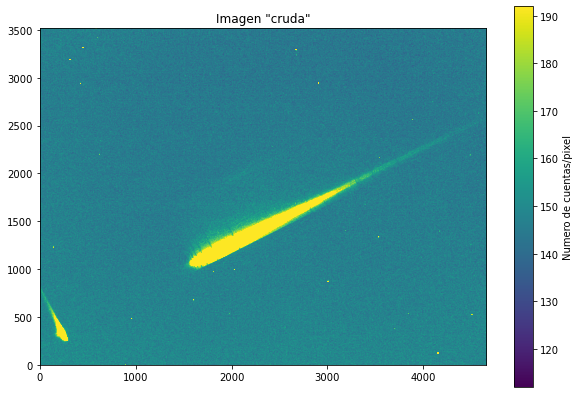

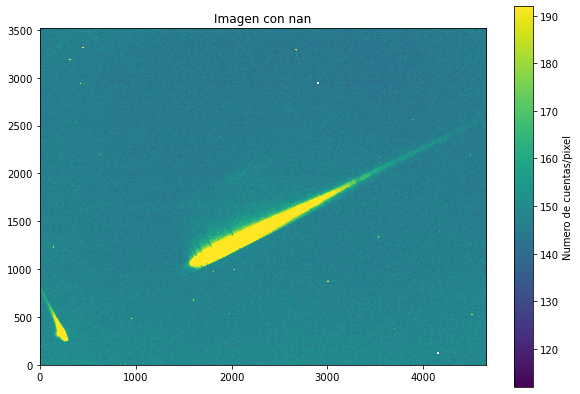

 
ARCHIVO: Vega_00001.fits
t_exp:  10 s


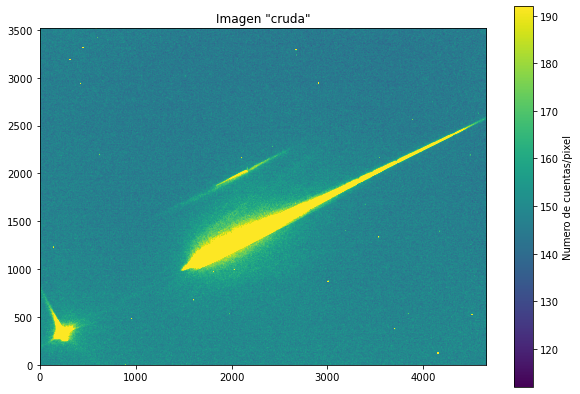

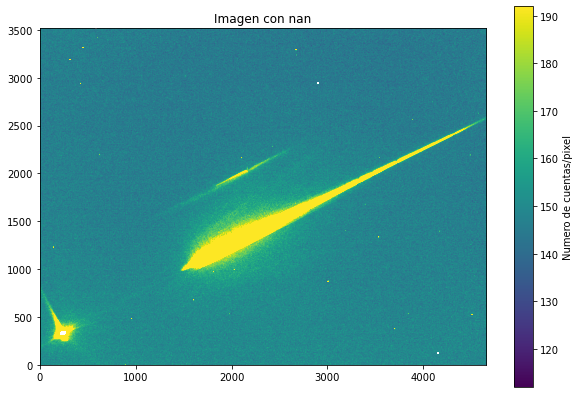

In [2]:
#%% REDUCCION DE DATOS

# Construir ruta a la carpeta donde estan los datos (todos)
dir_path = 'Vega' # Entrar en carpeta con los archivos        # Jupyter

print("--------------------------------------------------------------------------")    
print("                          IMAGENES SIN REDUCIR")
print("--------------------------------------------------------------------------")   

datafolder = os.path.join(dir_path, '21_38_01') # Entrar en carpeta de datos del objeto
# Primero prueba a leer directorios. Si no encuentra, lee archivos

listfiles = os.listdir(datafolder)  # obtiene lista con archivos/dir 

objeto_sucio = {}   # Objeto abierto tal cual
header_objeto = {}  # Variables interesantes del encabezado
data_save = []
header_save = []
# Barrido a todos los filtros:
data = [] # Para pintar uno de ejemplo
for dat in listfiles:
    file = os.path.join(datafolder,dat)
    print(' ')
    print('ARCHIVO:',dat) # Muestra el nombre del archivo abierto
    if os.path.splitext(file)[1]  == '.fits':
        image_header, data = redf.header_data(file,observatorio)
        print('t_exp: ' ,image_header.texp,'s')
        # El ultimo image_header abierto se usara para recortar 

        if pintar_datos_sucios is True:
            redf.show_data(data , permin = 5, permax = 95, cmapp = 'viridis', cbarname = 'Numero de cuentas/pixel', plot_name = 'Imagen "cruda"')                  
            
            # Inicializar matriz de mascara
            masc = np.ones(image_header.im_size)               
            sat_pix = np.where(data > Nsat)  # Buscar pixeles saturados
            masc[sat_pix] = np.nan # Rellenar con nan los pixeles saturados
            data = data * masc # Cambiar por nan los pixeles saturados
            data_save.append(data) # Guardar datos filtrados
            header_save.append(image_header) # Guardar las variables interesantes del header              

            if pintar_datos_sucios_nan is True:
                redf.show_data(data,  permin = 5, permax = 95, cmapp = 'viridis',  cbarname = 'Numero de cuentas/pixel', plot_name = 'Imagen con nan')    
        else:    
            print("El primer elemento de la carpeta no es un archivo")
    else:
        print("Esto no es una archivo .fits")


objeto_sucio = data_save
header_objeto = header_save

if ((pintar_last is True)&(len(data)>0)) is True:
    print("Ultima imagen abierta")
    redf.show_data(data, permin = 5, permax = 95, cmapp = 'viridis',  cbarname = 'Numero de cuentas/pixel', plot_name = 'Ultima imagen')    


## 1.2 Bias

El Bias se introduce para evitar registrar valores negativos de medida que puedan ser creados durante el proceso de lectura. Para medir este Bias, se toman imagenes con $t_{exp} = 0$ y con el obturador cerrado. De cuantas mas imagenes se disponga, mejor.

En este codigo, se hace una mediana (en cada pixel) de todos los Bias abiertos, si el bias se considera uniforme (es decir, las fluctiaciones son menores que un cierto valor), se sustituye el Bias por un valor constante (esta seccion de la funcion esta explicada en el material de reduccion_funciones.py, "redf.median_bias"). 

--------------------------------------------------------------------------
                               BIAS
--------------------------------------------------------------------------
ARCHIVO: Bias/bias_00002.fits
t_exp:  0 s


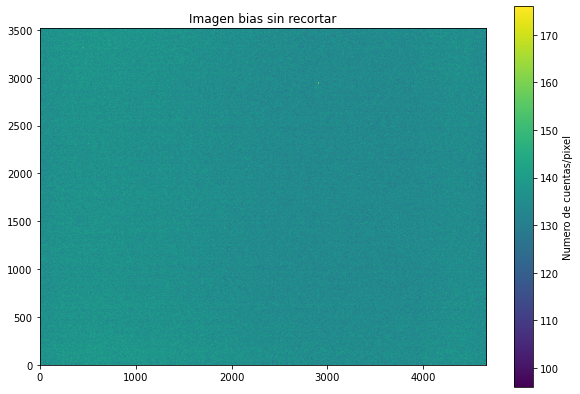

ARCHIVO: Bias/bias_00001.fits
t_exp:  0 s


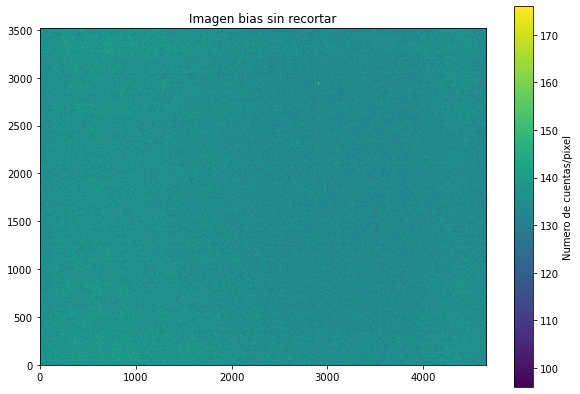

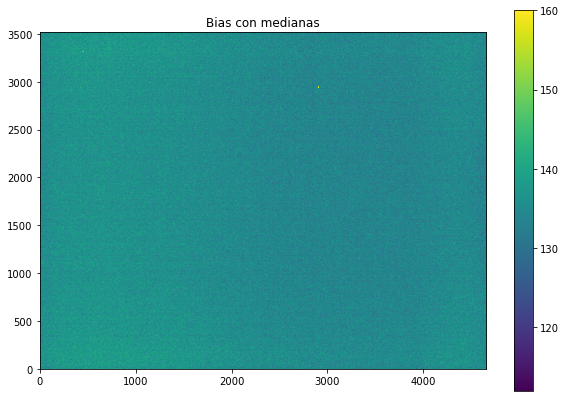

Bias merged. Bias size: (3520, 4656)
Bias mean value: 135.3
Numero de archivos de bias abiertos: 2


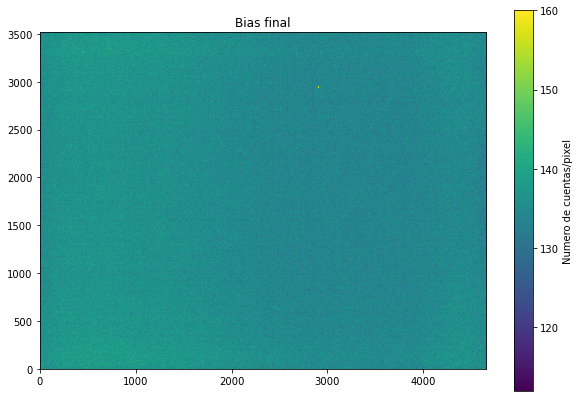

In [4]:
print("--------------------------------------------------------------------------")    
print("                               BIAS")
print("--------------------------------------------------------------------------")   

# Acceder a la carpeta de bias
biasfolder = Path(os.path.join('Bias'))

Bias, err_rayo, nbias = redf.median_bias(biasfolder.glob('*'),image_header, contrast = 2, num_sigma = 10,
                                         pintar_all = pintar_all_bias, pintar_final = pintar_final_bias, 
                                          observatorio = observatorio, treat_bias = treat_bias)

if nbias > 0:
    print('Bias merged. Bias size: {}'.format(np.shape(Bias)))
    print('Bias mean value: {:.4}'.format(np.mean(Bias)))
    print('Numero de archivos de bias abiertos:',nbias)
    if pintar_bias == True:
        redf.show_data(Bias, permin = 5, permax = 95, cmapp = 'viridis',  cbarname = 'Numero de cuentas/pixel', plot_name='Bias final')
else:
    print("No se han abierto archivos de Bias, se tomara por defecto bias = 0")


## 1.3 Dark

Esto es debido a la promocion de electrones en la CCD a la banda de conduccion por las excitaciones termicas (y no fotoelectricas, que es lo que realmente queremos medir). Para obtener $R_{dark}$ se toman imagenes con $t_{exp} \neq 0$ y el obturador cerrado, idealmente con tiempos parecidos a los de la imagen de ciencia. Esta corriente sigue la expresion:

 $ \large R'_{dark} [cuentas/s] = R_{dark} / G = \frac {\sum_{i = 1}^{n_{dark}}  C_{i,total} - C_{Bias}}{\sum_{i =1}^{n_{dark}} t_i}  = \frac {1} {n_{dark}} \frac {\sum_{i = 1}^{n_{dark}}  C_{i,total} - C_{Bias}}{t_{dark}}$

Se hace una media de todas las imagenes (dado que el tiempo de exposicion $t_{dark}$ es el mismo en todas ellas, siendo el numero total de ellas $n_{dark}$).

--------------------------------------------------------------------------
                               DARK
--------------------------------------------------------------------------
 
ARCHIVO: dark 60s_00001.fits
t_exp:  60 s


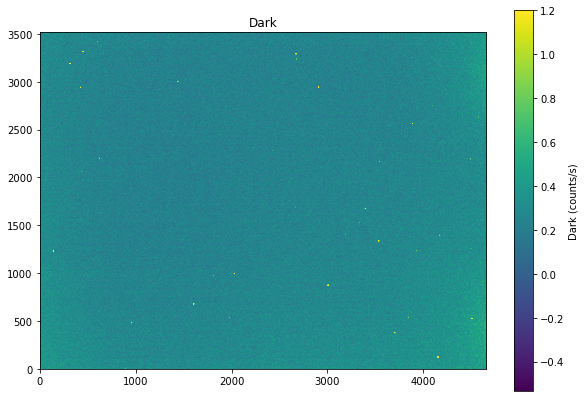

 
ARCHIVO: dark 60s_00002.fits
t_exp:  60 s


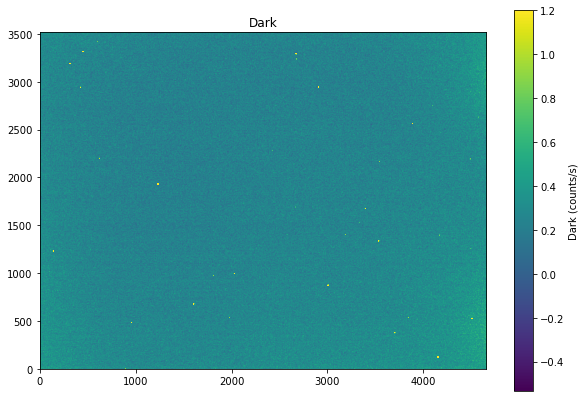

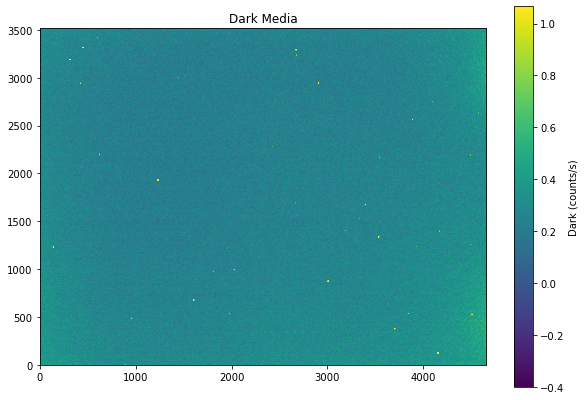

In [5]:
print("--------------------------------------------------------------------------")    
print("                               DARK")
print("--------------------------------------------------------------------------")   

# Acceder a la carpeta de Dark
darkfolder = Path(os.path.join('Dark'))
listfiles = os.listdir(darkfolder)  # obtiene lista con archivos/dir 
dark = {}   # Objeto abierto tal cual
header_dark = {}  # Variables interesantes del encabezado


# Barrido a todos los filtros:
data_dark = [] # Para pintar uno de ejemplo
dark_current = []
dark_images = []



for dat in listfiles:
    print(' ')
    file = os.path.join(darkfolder,dat)
    print('ARCHIVO:',dat) # Muestra el nombre del archivo abierto

    if os.path.splitext(file)[1]  == '.fits':
        header_dark, data_dark = redf.header_data(file,observatorio)
        t_dark = header_dark.texp
        print('t_exp: ' ,t_dark,'s')
        dark_current = (data_dark-Bias) / t_dark
        dark_images.append(dark_current) 
        if pintar_dark is True:
            redf.show_data(dark_current , permin=5, permax=95, cmapp = 'viridis', cbarname = 'Dark (counts/s)', plot_name = 'Dark')                  
        else:    
            print("El primer elemento de la carpeta no es un archivo")
    else:
        print("Esto no es una archivo .fits")
        
dark_current = np.mean(dark_images, axis = 0)

redf.show_data(dark_current , permin  = 5, permax = 95, cmapp = 'viridis', cbarname = 'Dark (counts/s)', plot_name = 'Dark Media')



## 1.4 Flat

No se calcula el Flat debido a que este resulta una correccion bastante inferior a la calibracion en flujo que se hara mas adelante. De todas formas, si se disponen de datos para calibrar con el, este se puede corregir (en nuestro caso no disponiamos de archivos flat). 

## 1.5 Tratamiento de la imagen

En estas lineas se tratan las imagenes sustrayendo el Bias y el Current Dark de los espectros obtenidos. Un tratamiento similar se hace a las imagenes de las lamparas. La funcion utilizada es "redf.im_reduction". Como el flat no se calcula, aqui se asume que Flat = 1 en todos los pixeles.

 $ \large reduced_{image} [cuentas/s]  = \frac{ (C_{total}-C_{bias}) - R'_{dark} t_{exp}}{Flat \cdot t_{exp}}      $



--------------------------------------------------------------------------
                     IMAGENES REDUCIDAS
--------------------------------------------------------------------------


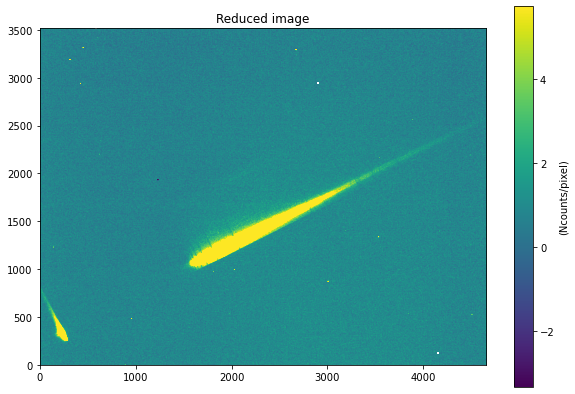

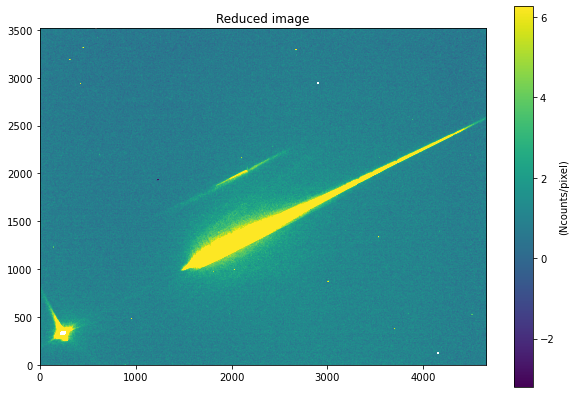

In [6]:
print("--------------------------------------------------------------------------")    
print("                     IMAGENES REDUCIDAS")
print("--------------------------------------------------------------------------")   

objeto_reduced = {}

obj_save = []
master_dark = dark_current

for i in range(0,len(objeto_sucio)):  # Se hace asi para coger el objeto y el header
    reduced_image = redf.im_reduction(objeto_sucio[i], header_objeto[i] , bias = Bias, flat = None, dark = master_dark)
    texp = header_objeto[i].texp
    obj_save.append(reduced_image) # Añadir imagen a la lista asociada al filtro
    
    if pintar_all_reduced==True:
        redf.show_data(reduced_image, permin = 5, permax = 95, cmapp = 'viridis', cbarname = '(Ncounts/pixel)', plot_name='Reduced image') 

objeto_reduced = obj_save 

# 2. Lampara: Calibracion en longitud de onda

De la imagen hay que sumar las cuentas en lineas a frecuencia constante, para ello nos serviremos de las lamparas para saber como se distribuyen (donde claramente se ven sus lineas de emision). Una vez sacada la recta del ajuste, sacamos el espectro de la lampara. Tambien se van a reducir sus imagenes con un tratamiento igual al anterior. 

Las imagenes de la lampara se usan para:

- Extraer la curva que se corresponde a longitudes de onda constante (luego se usara esa misma curva para el espectro del objeto que queramos estudiar).
- Sumar en esas lineas para extraer sus espectro.
- Comprobar que coinciden las lineas de emision de la lampara usada (Hg, Na...) con los picos del espectro, y asi poder hacer la calibracion en longitud de onda (pasar de posicion de los pixeles a $ \lambda $).


--------------------------------------------------------------------------
                      IMAGENES DE LAMPARA SIN REDUCIR
--------------------------------------------------------------------------


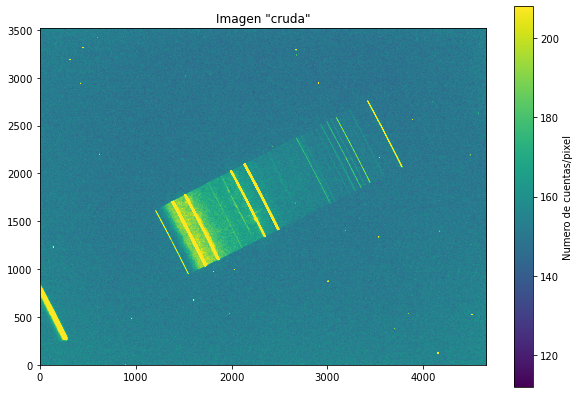

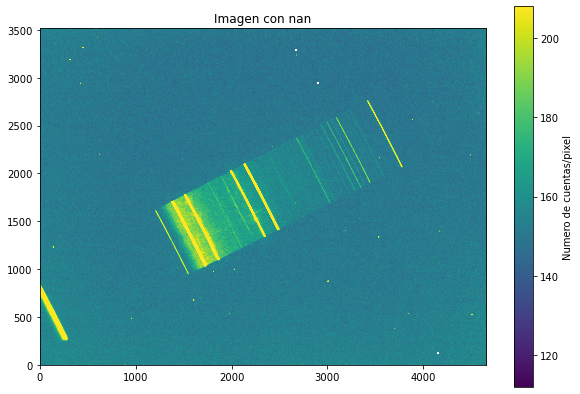

In [7]:
# Construir ruta a la carpeta donde estan los datos (todos)

dir_path = 'Hg' # Entrar en carpeta con los archivos   

print("--------------------------------------------------------------------------")    
print("                      IMAGENES DE LAMPARA SIN REDUCIR")
print("--------------------------------------------------------------------------")   

datafolder = os.path.join(dir_path, '20_16_51') # Entrar en carpeta de datos del objeto
# Primero prueba a leer directorios. Si no encuentra, lee archivos

listfiles = os.listdir(datafolder)  # obtiene lista con archivos/dir 

lampara_sucio = {}   # Objeto abierto tal cual
header_objeto = {}  # Variables interesantes del encabezado
data_save = []
header_save = []
# Barrido a todos los filtros:
data = [] # Para pintar uno de ejemplo
for dat in listfiles:
    file = os.path.join(datafolder,dat)
    if os.path.splitext(file)[1]  == '.fits':
        image_header, data = redf.header_data(file,observatorio)
        # El ultimo image_header abierto se usara para recortar 

        if pintar_datos_sucios is True:
            redf.show_data(data , permin=5, permax=95, cmapp = 'viridis', cbarname = 'Numero de cuentas/pixel', plot_name = 'Imagen "cruda"')                  
            # Inicializar matriz de mascara
            masc = np.ones(image_header.im_size)               
            sat_pix = np.where(data > Nsat)  # Buscar pixeles saturados
            masc[sat_pix] = np.nan # Rellenar con nan los pixeles saturados
            data = data * masc # Cambiar por nan los pixeles saturados
            data_save.append(data) # Guardar datos filtrados
            header_save.append(image_header) # Guardar las variables interesantes del header              

            if pintar_datos_sucios_nan is True:
                redf.show_data(data,  permin=5, permax=95, cmapp = 'viridis',  cbarname = 'Numero de cuentas/pixel', plot_name = 'Imagen con nan')    
        else:    
            print("El primer elemento de la carpeta no es un archivo")
    else:
        print("Esto no es una archivo .fits")


lampara_sucio = data_save
header_objeto = header_save

if ((pintar_last is True)&(len(data)>0)) is True:
    print("Ultima imagen abierta")
    redf.show_data(data, permin=5, permax=95, cmapp = 'viridis',  cbarname = 'Numero de cuentas/pixel', plot_name = 'Ultima imagen')    

## 2.1 Tratamiento de las imagenes de las lamparas

--------------------------------------------------------------------------
                     IMAGENES REDUCIDAS - LAMPARA
--------------------------------------------------------------------------


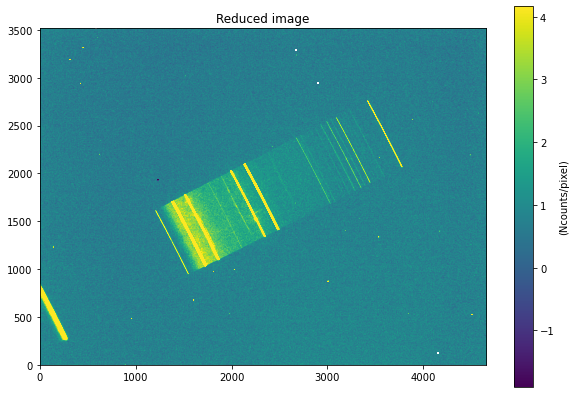

In [8]:
print("--------------------------------------------------------------------------")    
print("                     IMAGENES REDUCIDAS - LAMPARA")
print("--------------------------------------------------------------------------")   

lampara_reduced = []    
for i in range(0, len(lampara_sucio)):  # Se hace asi para coger el objeto y el header
    reduced_image = redf.im_reduction(lampara_sucio[i], header_objeto[i] , bias = Bias, flat = None ,dark = master_dark)
    texp = header_objeto[i].texp
    lampara_reduced.append(reduced_image) # Añadir imagen a la lista asociada al filtro
    
    if pintar_all_reduced==True:
        redf.show_data(reduced_image, permin = 5, permax = 95, cmapp = 'viridis', cbarname = '(Ncounts/pixel)', plot_name='Reduced image')


## 2.2 Ajuste en longitud de onda

Como se ve, las lineas diagonales que aparecen en las imagenes de la lampara son las curvas que estan sobre una longitud de onda constante. Ahora debemos intentar averiguar como es esta curva (si es una recta, una parabola, o si preferimos ajustarla a un polinomio de grado n) para asi poder sumar el espectro del objeto que queremos estudiar. En este caso se hara a una recta, que ajusta bastante bien (para el observatorio de la UAM).

Para ello, se efectuara un zoom en una linea facilmente identificable y se extraeran varias coordenadas de pixeles que se encuentren en esa linea en particular (puntos en el centro y los extremos de la linea). Se recomienda hacer el proceso al menos en 3 lineas (al principio, al medio y al final) para poder comprobar si varia la pendiente de la recta y, por tanto, intentar hacer una interpolacion de la pendiente (u otros parametros de la curva) en funcion de $\lambda$, por si estos parametros variaran. Aqui solo se ha usado la primera recta y se ha comprobado si funcionaba el ajuste en la ultima: proponemos que se haga como extra para mejorar el script en años futuros la interpolacion de los parametros segun la posicion de los pixeles.

Por ejemplo, para la primera linea se obtiene una pendiente de -1.93111993 y para la ultima una de -1.90595289. Como se ve, la diferencia es ~0.03, lo cual es bastante si estamos sumando en ~1000 pixeles. Esto se traducira en un error de 1 nm (aprox.) en los espectros obtenidos, que puede reducirse sacando una pendiente que varie segun la longitud de onda en la que estemos sumando.

![Lampara_Ejemplo_Lineas.png](Lampara_Ejemplo_Lineas.png)


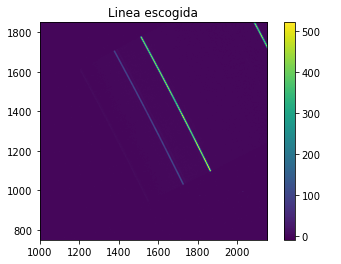

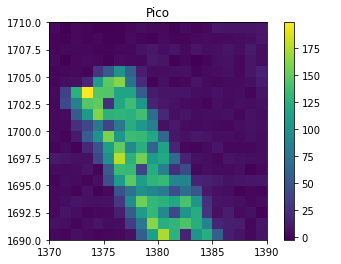

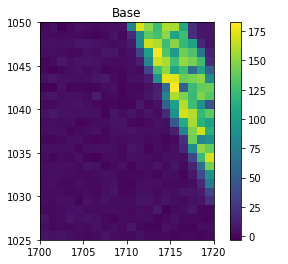

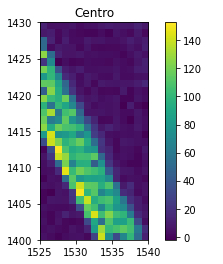

LINEA PRIMERA
coeficientes y = a + b*x
a:  [4359.87876652]
b:  [-1.93111993]
coeficiente R_squared: 0.9998458397726087


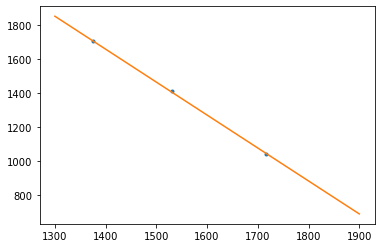

In [9]:
### Ajuste en longitud de onda LINEA 1: Escogemos una linea y tomamos varios puntos en ella (sus extremos, en el medio...)
# redf.show_data_with_axis() mantiene las coordenads de los pixeles donde se hace zoom (sin esto, empiezan en 0 los ejes)

# Linea escogida

y_1 = 750
y_2 = 1850
x_1 = 1000
x_2 = 2150
centro0 = [y_1, y_2, x_1, x_2]
diag = lampara_reduced[0][centro0[0]:centro0[1],centro0[2]:centro0[3]]
centro0 = [x_1, x_2, y_1, y_2]
redf.show_data_with_axis(diag, centro0 , cmapp = 'viridis', plot_name = 'Linea escogida', permin = 0.01, permax = 99.9)   

# Pico
y_1 = 1690
y_2 = 1710
x_1 = 1370
x_2 = 1390
centro0 = [y_1, y_2, x_1, x_2]
diag = lampara_reduced[0][centro0[0]:centro0[1],centro0[2]:centro0[3]]
centro0 = [x_1, x_2, y_1, y_2]
redf.show_data_with_axis(diag, centro0 , cmapp = 'viridis', plot_name = 'Pico', permin = 0.01, permax = 99.9)

# Base
y_1 = 1025
y_2 = 1050
x_1 = 1700
x_2 = 1720
centro0 = [y_1, y_2, x_1, x_2]
diag = lampara_reduced[0][centro0[0]:centro0[1],centro0[2]:centro0[3]]
centro0 = [x_1, x_2, y_1, y_2]
redf.show_data_with_axis(diag, centro0 , cmapp = 'viridis', plot_name = 'Base', permin = 0.01, permax = 99.9)

# Centro
y_1 = 1400
y_2 = 1430
x_1 = 1525
x_2 = 1540
centro0 = [y_1, y_2, x_1, x_2]
diag = lampara_reduced[0][centro0[0]:centro0[1],centro0[2]:centro0[3]]
centro0 = [x_1, x_2, y_1, y_2]
redf.show_data_with_axis(diag, centro0 , cmapp = 'viridis', plot_name = 'Centro', permin = 0.01, permax = 99.9)

# representacion de los puntos (recta de ajuste)

plt.figure(1)
punto_x = [1375,1717,1530]
punto_y = [1702,1042,1410]
plt.plot(punto_x,punto_y,'.')

# Ajuste a recta

y = np.array(punto_y).reshape((-1,1))
x = np.array(punto_x).reshape((-1,1))
model = LinearRegression().fit(x, y)

# y = a + b*x

a =  model.intercept_
b = model.coef_   # La conversion de pixel a landa (en nm)
print('LINEA PRIMERA')
print('coeficientes y = a + b*x')
print('a: ',a)
print('b: ',b[0])

r_sq = model.score(x, y)
print('coeficiente R_squared:', r_sq)

d = np.array([1300,1900])

plt.plot(d,a + b[0]*d)  # representacion de la recta ajustada


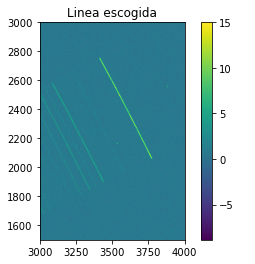

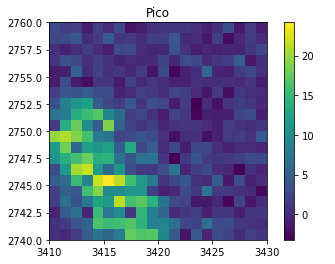

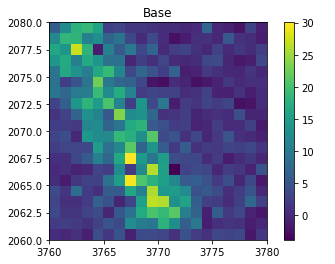

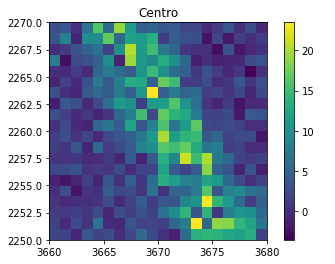

LINEA ULTIMA
coeficientes y = a + b*x
a:  [9251.00820502]
b:  [-1.90595289]
coeficiente R_squared: 0.9998672744430382


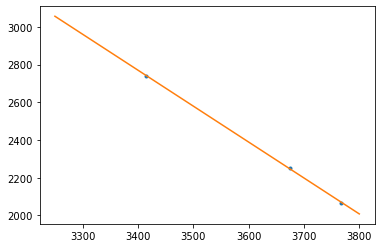

In [10]:
### Ajuste en longitud de onda LINEA 2: Escogemos una linea y tomamos varios puntos en ella (sus extremos, en el medio...)

# Linea escogida

y_1 = 1500
y_2 = 3000
x_1 = 3000
x_2 = 4000
centro0 = [y_1, y_2, x_1, x_2]
diag = lampara_reduced[0][centro0[0]:centro0[1],centro0[2]:centro0[3]]
centro0 = [x_1, x_2, y_1, y_2]
redf.show_data_with_axis(diag, centro0 , cmapp = 'viridis', plot_name = 'Linea escogida', permin = 0.01, permax = 99.9)

# Pico
y_1 = 2740
y_2 = 2760
x_1 = 3410
x_2 = 3430
centro0 = [y_1, y_2, x_1, x_2]
diag = lampara_reduced[0][centro0[0]:centro0[1],centro0[2]:centro0[3]]
centro0 = [x_1, x_2, y_1, y_2]
redf.show_data_with_axis(diag, centro0 , cmapp = 'viridis', plot_name = 'Pico', permin = 0.01, permax = 99.9)

# Base
y_1 = 2060
y_2 = 2080
x_1 = 3760
x_2 = 3780
centro0 = [y_1, y_2, x_1, x_2]
diag = lampara_reduced[0][centro0[0]:centro0[1],centro0[2]:centro0[3]]
centro0 = [x_1, x_2, y_1, y_2]
redf.show_data_with_axis(diag, centro0 , cmapp = 'viridis', plot_name = 'Base', permin = 0.01, permax = 99.9)

# Centro
y_1 = 2250
y_2 = 2270
x_1 = 3660
x_2 = 3680
centro0 = [y_1, y_2, x_1, x_2]
diag = lampara_reduced[0][centro0[0]:centro0[1],centro0[2]:centro0[3]]
centro0 = [x_1, x_2, y_1, y_2]
redf.show_data_with_axis(diag, centro0 , cmapp = 'viridis', plot_name = 'Centro', permin = 0.01, permax = 99.9)

# representacion de los puntos

plt.figure(1)
punto_x = [3674,3767,3415]
punto_y = [2253,2068,2741]
plt.plot(punto_x,punto_y,'.')

# Ajuste a recta

y = np.array(punto_y).reshape((-1,1))
x = np.array(punto_x).reshape((-1,1))
model = LinearRegression().fit(x, y)

# y = a + b*x

a =  model.intercept_
b = model.coef_   # La conversion de pixel a landa (en nm)
print('LINEA ULTIMA')
print('coeficientes y = a + b*x')
print('a: ',a)
print('b: ',b[0])
r_sq = model.score(x, y)
print('coeficiente R_squared:', r_sq)

d = np.array([3250,3800])

plt.plot(d,a + b[0]*d)
#plt.xlim(3760,3780) # por si se quiere hacer un zoom en los puntos representados
#plt.ylim(2060,2080)


### 2.2.1 Zona de suma para obtener el espectro

Ahora toca averiguar que region de la imagen queremos estudiar: como se ve, realmente nos interesa solo la traza diagonal del centro, lo demas es señal de fondo (que se reducen a 0 cuentas una vez restado el Dark, Bias...). Para ello nos debemos de asegurar que el rectangulo que consideremos (donde sumaremos las cuentas en frecuencia constante para sacar el espectro) sea lo suficientemente grande para que a su vez contenga los datos de las lamparas y del objeto. Las dimensiones del rectangulo deberian ser iguales en ambas imagenes (lampara y objeto), porque es posible que el comportamiento de las lineas sean distintas a distintas longitudes de onda (la recta antes inferida varie, por ejemplo, y asi se pueda acomodar mas facilmente esta variacion al obtener el espectro).

Haremos varios zooms en las imagenes para averiguar el rectangulo (esto es, donde empezamos a sumar y donde acabamos).

![Rectangulo_Suma_Lineas.png](Rectangulo_Suma_Lineas.png)

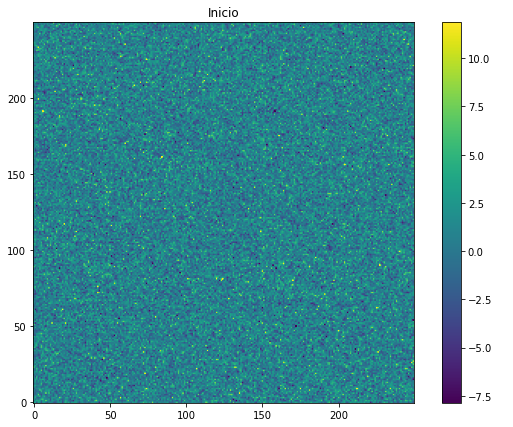

In [11]:
# Obtencion de x0, y0

centro0 = [900-200, 900+50, 1400-200, 1400+50] # escogemos una zona donde ya no se vea el espectro (las cuentas sean 0 salvo fluctuaciones ligeras)
diag = objeto_reduced[0][centro0[0]:centro0[1],centro0[2]:centro0[3]]
redf.show_data(diag, cmapp = 'viridis',plot_name = 'Inicio')
[y0,x0] = [900, 1400]

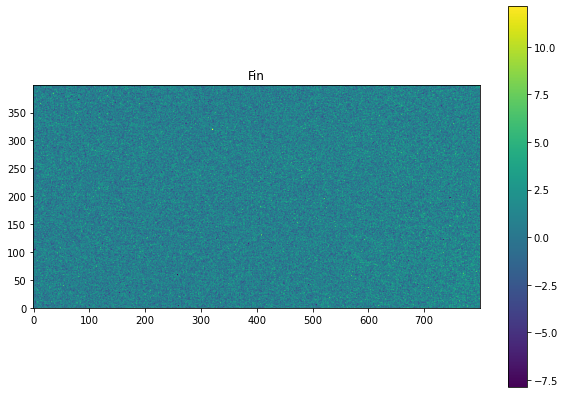

In [12]:
# Obtencion de xmax, ymax

centro0 = [900 + 500, 900 + 900, 1400 - 400, 1400 + 400]  # escogemos una zona donde ya no se vea el espectro (las cuentas sean 0 salvo fluctuaciones ligeras)
diag = objeto_reduced[0][centro0[0]:centro0[1],centro0[2]:centro0[3]]
redf.show_data(diag, cmapp = 'viridis',plot_name = 'Fin')
[ymax,xmax] = [900+700, 1400-400]

### 2.2.2 Extraccion del espectro de la lampara

Para obtener el espectro sumamos de la siguiente forma:

- el primer for es sobre una curva perpendicular a la parabola/recta... donde se consideran los pixeles a longitud de onda constante, es decir, se mueve en el eje x de la imagen (en este caso el superior). 
- en el segundo for nos movemos hacia abajo en cada punto del eje x superior que nos encontremos, y sumamos las cuentas de cada pixel que recorremos en este for.

$ y = (1/1,93111993)(x-x_0) + y_0 $ , EJE X INFERIOR   ,  $ [y_0,x_0] = [900,1400] $

$ y = (1/1,93111993)(x-x_{max}) + y_{max} $ , EJE X SUPERIOR   ,  $ [y_{max},x_{max}] = [900+700,1400-400] $

Notese que los ejes tienen rectas perpenciculas a las inferidas para $ \lambda $ constante.

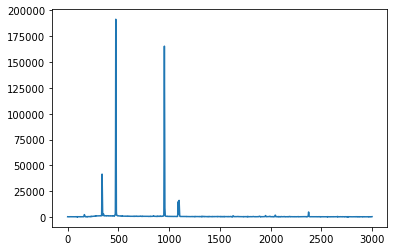

In [13]:
# Ejes
[y0,x0] = [900,1400]
[ymax,xmax] = [900+700,1400-400]

n_max = 3000 # longitud eje x en pixeles
m_max = 700 # longitud eje y en pixeles

suma_lampara = np.zeros(n_max)

for n in range(0,n_max):
    
    for i in range(xmax+n,x0+n):
        
        suma_lampara[n] = suma_lampara[n] + lampara_reduced[0] [int(np.round( ymax + (1/1.93111993)*(n) - 1.93111993*(i-xmax-n))) , i]
        
plt.plot(suma_lampara)

    

### 2.2.3 Representacion del espectro de la lampara

Para poder calibrar en longitudes de onda debemos encontrar los picos de emision de la lampara y compararlos con los valores en nm de la literatura ("MercuryWavelengths.pdf"). En este caso, por facilidad, se ha usado tambien las lineas $H\alpha $, $H\beta $, $H\gamma $ y $H\delta $ del espectro de la estrella, pues estos picos de absorcion son facilmente identificables, no tanto como los picos de la lampara. De hecho, primero usamos solo las lineas de absorcion de la estrella para hacer una primera aproximacion de donde caen las lineas de la lampara (muchas veces, se observan mas lineas que las tabuladas y es dificil su identificacion).


Text(0.5, 1.0, 'Espectro lampara de Hg')

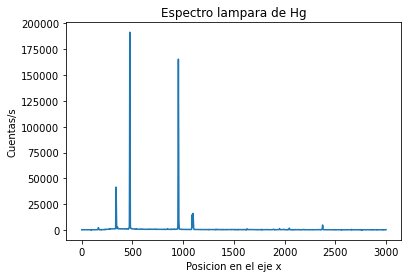

In [14]:
n =  np.arange(0,n_max,1)
plt.plot(n,suma_lampara,'-',)
#plt. xlim(1000, 2000)

plt.xlabel('Posicion en el eje x')
plt.ylabel('Cuentas/s')
plt.title('Espectro lampara de Hg')

Zoom en regiones para obtener los pixeles en los que tenemos los picos. Idealmente deberiamos tener picos con forma de Gaussiana, si no fuese asi se recomienda hacer un nuevo ajuste para inferir las curvas a longitud de onda constante.

Text(0, 0.5, 'Cuentas/s')

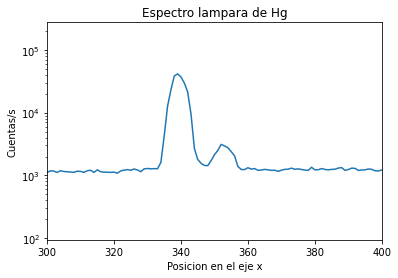

In [15]:
n =  np.arange(0,n_max,1)

plt.plot(n,suma_lampara,'-',)
plt.yscale('log')
plt.xlim(300, 400)
plt.title('Espectro lampara de Hg')
plt.xlabel('Posicion en el eje x')
plt.ylabel('Cuentas/s')

### 2.2.4 Extraccion del espectro del objeto

Igual que en la lampara, y usamos los mismos ejes.

Text(0, 0.5, 'Cuentas/s')

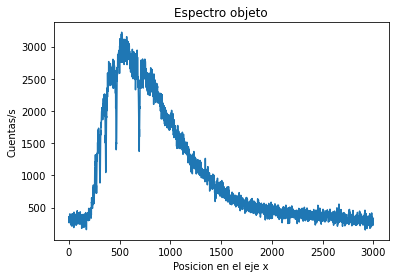

In [16]:
# Ejes 
[y0,x0] = [900, 1400]
[ymax,xmax] = [900+700, 1400-400]

n_max = 3000 # longitud eje x
m_max = 700 # longitud eje y

suma_objeto = np.zeros(n_max)

# Nos quedamos solo con objeto_reduced[0] porque es el mejor espectro que teniamos, los otros tenian mucho ruido asociado
# y se considero que no se podian tratar correctamente

for n in range(0,n_max):
    
    for i in range(xmax+n, x0+n):

        suma_objeto[n] = suma_objeto[n] + objeto_reduced[0] [int(np.round(ymax + (1/1.93111993)*(n) - 1.93111993*(i-xmax-n))) , i]


n_objeto = np.arange(0,n_max,1)
plt.plot(n_objeto,suma_objeto,'-',)
#plt. xlim(1000, 2000)
plt.title('Espectro objeto')
plt.xlabel('Posicion en el eje x')
plt.ylabel('Cuentas/s')

## 2.3 Calibracion en longitud de onda

Se representan en una grafica los pixeles donde se encuentran las lineas (obtenidas en el espectro) respecto de las longitudes de onda donde ocurren estas lineas. A partir de ello, la pendiente de la recta que une los puntos sera la conversion (si una recta no es un buen ajuste, se puede hacer a un polinomio de orden n). 

coeficientes y = a + b*x
a:  [328.26668674]
b:  [0.22791988]
coeficiente R_squared: 0.9999866414170749


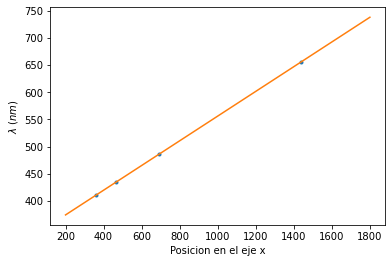

In [17]:
# Primera aproximacion: esto es para saber mas o menos las lineas de las lamparas donde caen y poder comparar con el espectro tabulado de las mismas.
# Luego se incluyen los puntos de las lamparas y asi se tienen mas para inferir la correccion en longitud de onda.

pixels = [1440, 690, 464, 361] # posiciones de los picos de absorcion
landa = [656.3, 486.1, 434.0, 410.17]   # nm lineas H (alfa, beta, gamma, delta)

plt.plot(pixels,landa,'.')  # Inferir la recta que une los puntos: la conversion
plt.ylabel('$\lambda$ ($nm$)')
plt.xlabel('Posicion en el eje x')


# Ajuste a recta
x = np.array(pixels).reshape((-1,1))
y = np.array(landa).reshape((-1,1))
model = LinearRegression().fit(x, y)



# y = a + b*x

a =  model.intercept_
b = model.coef_   # La conversion de pixel a landa (en nm)

print('coeficientes y = a + b*x')
print('a: ',a)
print('b: ',b[0])
#print('b: ',b[1])
r_sq = model.score(x, y)
print('coeficiente R_squared:', r_sq)
d = np.array([200,1800])

plt.plot(d,a + b[0]*d)
#plt. xlim(686, 695)
#plt. ylim(482 ,487)

# Pasamos de pixel a landa

landa_medido = a + b[0]*n 
landa_0 = landa_medido[0]  # primera longitud de onda del espectro
landa_fin = landa_medido[-1] # ultima longitud de onda del espectro

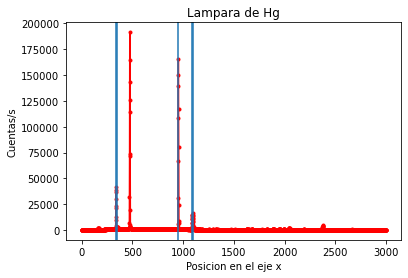

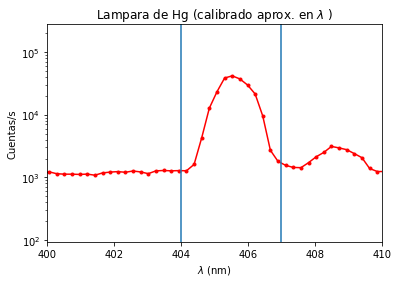

In [18]:
# Inlcuimos la lampara, ahora que tenemos una aproximacion de donde caen las lineas de emision tabuladas de la lampara

pixels = [1440, 690, 464, 361, 338, 352, 951, 1087, 1096]
landa = [656.3, 486.1, 434.0, 410.17, 404, 407, 546, 576,579]

plt.figure(1)
plt.plot(suma_lampara,'r.-')
plt.title('Lampara de Hg')
plt.xlabel('Posicion en el eje x')
plt.ylabel('Cuentas/s')

#plt.yscale('log')  # Aqui se recomienda, al hacer zoom, usar escala logaritmica
#plt. xlim(1075,1110)
#plt.axvline(164)  # algunas lineas las eliminamos por no aparecer en el espectro tabulado
#plt.axvline(338)
#plt.axvline(352)
plt.axvline(338)
plt.axvline(352)
plt.axvline(951)
plt.axvline(1087)
plt.axvline(1096)

# Representacion aproximada, para saber mas o menos donde caen las lineas tabuladas (pues suelen salir mas lineas que las tabuladas)

n_lampara =  np.arange(0,n_max,1)
landa_medido_lampara = a + b[0]*n_lampara

plt.figure(2)
plt.plot(landa_medido_lampara,suma_lampara,'r.-',)
plt. xlim(400,410)
#plt. ylim(0, 1e4)
plt.yscale('log')
plt.title('Lampara de Hg (calibrado aprox. en $\lambda$ )')
plt.xlabel('$\lambda$ (nm)')
plt.ylabel('Cuentas/s')

#plt.axvline(334)
#plt.axvline(365)
#plt.axvline(366)
plt.axvline(404)
plt.axvline(407)
#plt.axvline(434)
#plt.axvline(435)
plt.axvline(546)
plt.axvline(576)
plt.axvline(579)



coeficientes y = a + b*x : conversion de pixel a landa
a:  [327.22155159]
b:  [0.22917481]
coeficiente R_squared: 0.9999405981425689


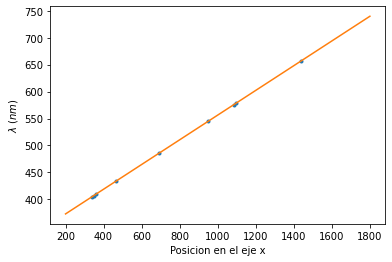

In [19]:
# Ajuste a recta final

plt.plot(pixels,landa,'.')  # Inferir la recta, la pendiente es la conversion
plt.ylabel('$\lambda$ ($nm$)')
plt.xlabel('Posicion en el eje x')


x = np.array(pixels).reshape((-1,1))
y = np.array(landa).reshape((-1,1))
model = LinearRegression().fit(x, y)



# y = a + b*x

a =  model.intercept_
b = model.coef_   # La conversion de pixel a landa (en nm)
print('coeficientes y = a + b*x : conversion de pixel a landa')
print('a: ',a)
print('b: ',b[0])
#print('b: ',b[1])
r_sq = model.score(x, y)
print('coeficiente R_squared:', r_sq)
d = np.array([200,1800])

# pixels = [1440, 690, 464, 361, 338, 352, 951, 1087, 1096]
# landa = [656.3, 486.1, 434.0, 410.17, 404, 407, 546, 576,579]

plt.plot(d,a + b[0]*d)

#plt. xlim(1400, 1600)  # zoom para comprobar
#plt. ylim(600, 700)


# Pasamos de pixel a landa tanto para la lampara como para el objeto

landa_medido_lampara = a + b[0]*n_lampara 
landa_medido = a + b[0]*n_objeto 
landa_0 = landa_medido[0]  # primera longitud de onda del espectro
landa_fin = landa_medido[-1] # ultima longitud de onda del espectro

# 3. Calibracion en flujo

Se usa el espectro de la estrella ya tabulado para calibrar en flujo, ahora que ya tenemos la calibracion en longitudes de onda. Esto sirve para sacar la conversion de cuentas a flujo, es decir, extraer la curva de respuesta del instrumento para usarla en las otras observaciones que se hagan. Para ello, usamos Vega que ya tenemos su espectro tabulado.

## 3.1 Representacion del espectro tabulado

(1e-10, 1e-07)

<Figure size 432x288 with 0 Axes>

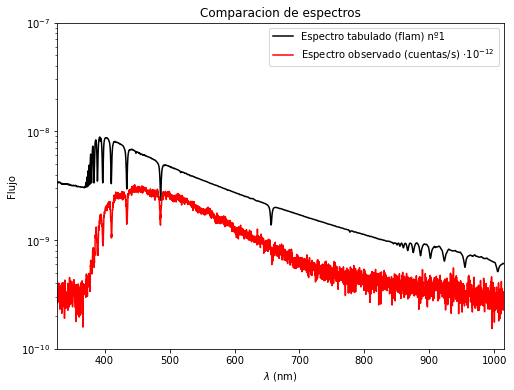

In [20]:
plt.figure(1)
plt.figure(figsize=(8, 6))

plt.plot(landa_medido,suma_objeto,'-b')
plt.title('Espectro Vega')
plt.xlabel('$\lambda$ (nm)')
plt.ylabel('flujo (sin convertir)')
plt. xlim(landa_0, landa_fin)


dir_path = 'EspectroTabuladoVega'   # Entrar en carpeta con los archivos del espectro tabulado 
landa_fin = landa_medido[-1]        # Ultima longitud de onda del espectro
datafolder = os.path.join(dir_path) # Entrar en carpeta de datos del objeto
# Primero prueba a leer directorios

listfiles = os.listdir(datafolder)  # obtiene lista con archivos/dir
i = 0
for dat in listfiles:
    file = os.path.join(datafolder,dat)
    if os.path.splitext(file)[1]  == '.fits':
        i = i + 1
        hdu = fits.open(file)
        tabla = hdu[1]
        Flujo_tabulado = tabla.data['FLUX']  # unidades flam [erg s-1 cm-2 A-1 (Angstrong)]
        Landa_tabulado = tabla.data['WAVELENGTH']/10
        plt.plot(Landa_tabulado, Flujo_tabulado,'-k', label = 'Espectro tabulado (flam) nº' + str(i))
        plt. xlim(landa_0, landa_fin)
        plt.title('Espetro tabulado Vega')
        
plt.yscale('log')

plt.plot(landa_medido, suma_objeto/(10**(12)),'r-', label = 'Espectro observado (cuentas/s) $ \cdot 10^{-12} $')
plt.title('Comparacion de espectros')
plt.ylabel('Flujo')
plt.xlabel('$\lambda$ (nm)')
plt.legend()
plt.ylim(1e-10,1e-7)


## 3.2 Interpolacion y curva de respuesta

Debemos interpolar el array de las longitudes de onda de los espectros para que todos tengan el mismo equiespaciado, ademas de que empiecen y acaben en el mismo punto (el tabulado tiene mas rango que el observado). Una vez interpolado, podemos dividir un espectro sobre el otro para obtener la curva de respuesta y la conversion de cuentas a flujo.

Como el espectro no es una curva suave, no se recomienda hacer una interpolacion en ambos y hacer la division directamente, sino que debemos suavizar ambos (la curva de respuesta no depende de las caidas del flujo por las lineas de emision/absorcion, solo del instrumento). Para ello haremos la interpolacion para n saltos (numero_bines). No se recomienda ni que el numero_bines sea muy grande, porque entonces ya estariamos tomando puntos dentro de las lineas de emision/absorcion, ni muy pequeño, pues estariamos perdiendo la estructura del espectro y aumentariamos el error.

Para suavizarlos, se hara una integral del flujo en cada salto (numero_bines) y luego se derivara el resultado obtenido. La division entre espectro_tabulado/espectro_medido sera la respuesta del instrumento que se podra usar para los otros objetos que se hayan observado. Es importante que los espectros suavizados finales no tengan puntos justo en las lineas de absorcion (es la razon de porque lo estamos suavizando en un primer lugar). 


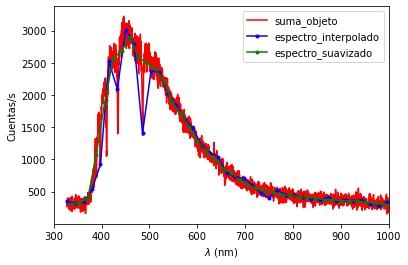

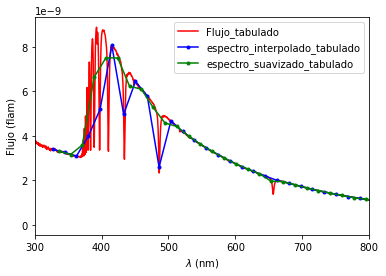

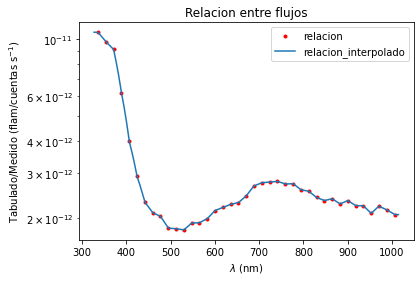

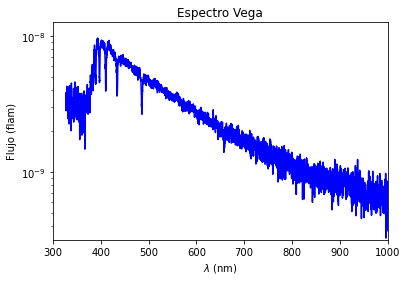

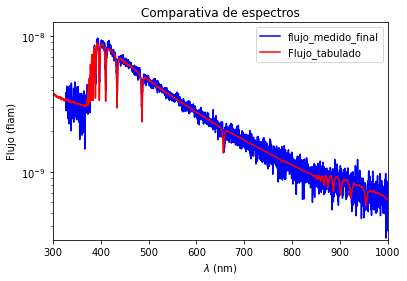

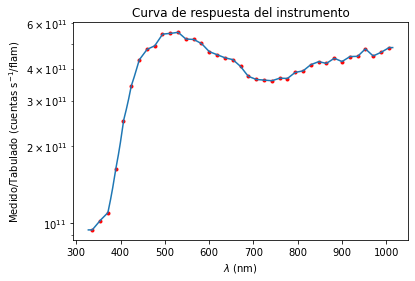

In [21]:
# Interpolamos el espectro medido para poder calibrarlo (tambien hay que interpolar el espectro tabulado)

numero_bines = 40

plt.figure(1)
plt.plot(landa_medido,suma_objeto,'r-', label = 'suma_objeto')

# numpy.interp(x, xp, fp)
# Returns the one-dimensional piecewise linear interpolant to a function with given discrete data points (xp, fp), evaluated at x.

landa_interpolado = np.linspace(np.min(landa_medido), np.max(landa_medido),numero_bines)
espectro_interpolado = np.interp(landa_interpolado, landa_medido, suma_objeto)
plt.plot(landa_interpolado, espectro_interpolado, 'b.-', label = 'espectro_interpolado')

# Integramos para interpolar para luego derivar y asi suavizar

delta_landa_original = landa_medido[1:] - landa_medido[:-1]
espectro_acumulado = np.concatenate([np.array([0]), np.cumsum(suma_objeto[:-1]*delta_landa_original)]) # hacemos la integral como una suma de Riemann

# Derivamos

landa_suavizado = (landa_interpolado[1:] + landa_interpolado[:-1])/2
delta_landa_interpolado = landa_interpolado[1:] - landa_interpolado[:-1]
espectro_acumulado_suavizado = np.interp(landa_interpolado, landa_medido, espectro_acumulado) # debemos interpolar otra vez

espectro_suavizado = (espectro_acumulado_suavizado[1:] - espectro_acumulado_suavizado[:-1])/delta_landa_interpolado # hacemos la derivada

plt.plot(landa_suavizado, espectro_suavizado,'g.-', label = 'espectro_suavizado')

plt.xlabel('$\lambda$ (nm)')
plt.ylabel('Cuentas/s')
#plt.xlim(350,450)
plt.xlim(300,1000)
#plt.yscale('log')
#plt.xlim(800,900)
plt.legend()


# Hacemos lo mismo para el espectro tabulado

plt.figure(2)
plt. xlim(landa_0, landa_fin)
plt.xlabel('$\lambda$ (nm)')
plt.ylabel('Flujo (flam)')
plt.plot(Landa_tabulado, Flujo_tabulado, 'r-', label = 'Flujo_tabulado')

# como el array de landas del espectro tabualdo tiene mas rango que el medido, debemos identificar en que region estamos 

pos_1_tabulado = np.where(Landa_tabulado > landa_0)
pos_1_tabulado = pos_1_tabulado[0][0]

pos_2_tabulado = np.where(Landa_tabulado > landa_fin)
pos_2_tabulado = pos_2_tabulado[0][0]

landa_interpolado_tabulado = np.linspace(Landa_tabulado[pos_1_tabulado], Landa_tabulado[pos_2_tabulado],numero_bines)
espectro_interpolado_tabulado = np.interp(landa_interpolado_tabulado, Landa_tabulado, Flujo_tabulado)
plt.plot(landa_interpolado_tabulado, espectro_interpolado_tabulado, 'b.-', label = 'espectro_interpolado_tabulado')

# Integramos para interpolar para luego derivar y asi suavizar

delta_landa_original_tabulado = Landa_tabulado[1:] - Landa_tabulado[:-1]
espectro_acumulado_tabulado = np.concatenate([np.array([0]), np.cumsum(Flujo_tabulado[:-1]*delta_landa_original_tabulado)])

landa_suavizado_tabulado = (landa_interpolado_tabulado[1:] + landa_interpolado_tabulado[:-1])/2
delta_landa_interpolado_tabulado = landa_interpolado_tabulado[1:] - landa_interpolado_tabulado[:-1]
espectro_acumulado_suavizado_tabulado = np.interp(landa_interpolado_tabulado, Landa_tabulado, espectro_acumulado_tabulado)

# Derivamos
espectro_suavizado_tabulado = (espectro_acumulado_suavizado_tabulado[1:]-espectro_acumulado_suavizado_tabulado[:-1])/delta_landa_interpolado_tabulado

plt.plot(landa_suavizado_tabulado, espectro_suavizado_tabulado, 'g.-', label = 'espectro_suavizado_tabulado')
#plt.xlim(350,450)
plt.xlim(300,800)
plt.legend()


# Calculo de relacion

relacion = espectro_suavizado_tabulado/espectro_suavizado
relacion_interpolado = np.interp(landa_medido, landa_suavizado, relacion)

# Representamos la conversion de flujo para ver como actua nuestro detector en funcion de la longitud de onda (como se ve, no es constante)

plt.figure(3)
plt.plot(landa_suavizado,relacion, '.r',label = 'relacion')
plt.plot(landa_medido, relacion_interpolado, label = 'relacion_interpolado')

plt.title('Relacion entre flujos')
plt.xlabel('$\lambda$ (nm)')
plt.ylabel('Tabulado/Medido (flam/cuentas s$ ^{-1} $)')
plt.yscale('log')
plt.legend()


flujo_medido_final = relacion_interpolado*suma_objeto



# Representacion final
        
plt.figure(4)

plt.title('Espectro medido Vega calibrado')
plt.plot(landa_medido, flujo_medido_final, '-b')
#plt.plot(Landa_tabulado, Flujo_tabulado,'r-', label = 'Flujo_tabulado')
plt.title('Espectro Vega')
plt.xlabel('$\lambda$ (nm)')
plt.ylabel('Flujo (flam)')
plt.xlim(landa_0, landa_fin)
#plt.xlim(300,800)
plt.xlim(300,1000)
plt.yscale('log')
plt.ylim(10**(-9.5),10**(-7.9))

plt.figure(5)

plt.title('Comparativa de espectros')
plt.plot(landa_medido, flujo_medido_final, '-b', label = 'flujo_medido_final')
plt.plot(Landa_tabulado, Flujo_tabulado, 'r-', label = 'Flujo_tabulado')
plt.xlabel('$\lambda$ (nm)')
plt.ylabel('Flujo (flam)')
plt.xlim(landa_0, landa_fin)
plt.yscale('log')
plt.ylim(10**(-9.5),10**(-7.9))
#plt.xlim(300,800)
plt.xlim(300,1000)
# plt.xlim(480,490) # si hacemos zoom en una linea, vemos que hay un error de ~1nm
plt.legend()

# la curva de respuesta es la inversa de la relacion

plt.figure(6)
plt.plot(landa_suavizado,1/relacion, '.r')
plt.plot(landa_medido, 1/relacion_interpolado)
plt.title('Curva de respuesta del instrumento')
plt.xlabel('$\lambda$ (nm)')
plt.ylabel('Medido/Tabulado (cuentas s$ ^{-1} $/flam)')
plt.yscale('log')


## 3.3 Espectro final calibrado

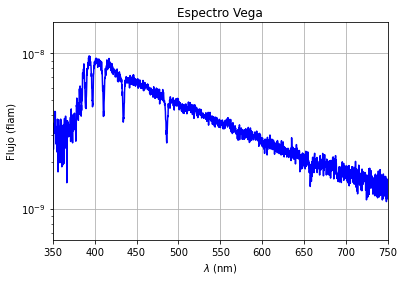

In [22]:
plt.plot(landa_medido, flujo_medido_final,'-b')

plt.title('Espectro Vega')
plt.xlabel('$\lambda$ (nm)')
plt.ylabel('Flujo (flam)')
#plt.xlim(landa_0, landa_fin)
#plt.xlim(300,800)
plt.xlim(350,750)  # escogemos el rango bueno de medida
plt.ylim(10**(-9.2),10**(-7.8))
plt.yscale('log')
plt.grid()

# 4. Comentarios

- Si hacemos un zoom en las lineas de absorcion de la lampara, vemos que hay un error de ~ 1 nm. Para evitarlo, recomendamos variar las curvas para sumar las cuentas a longitud de onda constante segun nos desplazamos a lo largo del llamado eje x, tal como se ha indicado anteriormente (en Calar Alto, el espectro no sale en diagonal como en la UAM y en principio deberia ser mas facil sacar los ejes y estas curvas). Aun asi, nuestro error de ~ 1 nm es sistematico (en la recta de ajuste pixel - landa no se ve una tendencia de los puntos a estar por debajo o encima de la recta, sino que van distribuidos con una cierta aleatoriedad cerca de la recta), pero definitivamente deberia reducirse algo este error en longitud de onda si hiciesemos la interpolacion de los parametros de estas curvas, pues ya vimos que la pendiente variaba de la primera a la ultima linea de emision de la lampara.

- No es una buena calibracion de flujo a landas distintas de (400,700) nm (aprox.). Una razon es que de 300 a 400 nm (el principio del espectro) la curva de respuesta (figura relacion entre flujos) varia mucho en este rango de longitudes de onda, asi que se recomienda que en esta region la interpolacion se haga con mas densidad de puntos que en las otras.

- Luego, el hecho de que el flujo sea especialmente bueno en este rango (400,700) nm se deberia explicar tambien por el grisma usado, que tiene un rango de eficiencia de deteccion. Esto se puede ver claro en la respuesta del instrumento, que tiene el maximo en este rango de longitues de onda.

- Si el objeto observado tiene algun tipo de corrimiento al rojo/azul, se debe considerar en la calibracion en longitud de onda (Vega tiene un blueshift de 0.02 nm aproximadamente, menor que el error que tenemos en las longitudes de onda y por eso no se ha corregido). 